In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import copy
import itertools
import time

import gensim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
from scipy.sparse import csgraph
from scipy.stats import bayes_mvs
from scipy.stats import ttest_ind
import pandas as pd

import networkx as nx

import sampl.gsn_api as gsn
import sampl.semantics as sem
import sampl.update as update
import sampl.agent as agent

In [2]:
sns.set(font_scale=1.6)

# Memory synchronization in communicating agents
 
We embedded the model in a pair of agents to test if communication produced memory synchronization. 

## Operationalizing conversation

Conversation was operationalized as series of exchanges. In each exchange one agent, designated the sender, selects a starting word by taking the mean in-degrees of all of its nodes, normalizing them to create a probability distribution, and taking a random draw from that distribution. The sender then selects a paired associate of the starting word by normalizing the outbound edge weights from the starting word to create a probability distribution, then taking a random draw from that distribution. The starting word and its paired associate are then simultaneously activated in the other agent, designated the receiver. Finally, the process is repeated, with the sender and receiver roles reversed.

In [3]:
google_news_w2v_path = '../data/GoogleNews-vectors-negative300.bin'
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
words_a = [
    'income',
    'inequality',
    'wealthy',
    'rich',
    'poor',
    'tax',
    'liberal',
    'conservative'
]

In [5]:
dsm_a = sem.semantic_dsm(words_a, google_news)
graph_a = sem.SemanticGraph(dsm=dsm_a, labels=words_a)
discount = .3

my_update = update.get_update(
    dip_center=.3,
    dip_width=.4,
    y_min=-.025,
    y_max=.15
)
op_a = gsn.GraphOperator(
    graph=graph_a, 
    operate_fx=gsn.operate_recur, 
    update_fx=my_update, 
    discount=discount
)

dsm_a_shuffled = copy.copy(dsm_a)
np.random.shuffle(dsm_a_shuffled)
graph_b = sem.SemanticGraph(dsm=dsm_a_shuffled, labels=words_a)
op_b = gsn.GraphOperator(
    graph=graph_b, 
    operate_fx=gsn.operate_recur, 
    update_fx=my_update, 
    discount=discount
)

In [6]:
alice = agent.Agent('Alice', op=copy.deepcopy(op_a), learning_rate=.5)
bob = agent.Agent('Bob', op=copy.deepcopy(op_b), learning_rate=.5)

"Hello world, I'm Alice."
"Hello world, I'm Bob."


In [7]:
alice.start_episode()
bob.start_episode()

Alice is listening
Bob is listening


In [8]:
def plot_pair_heatmap(agent_a, agent_b, highlight_a=None, highlight_b=None, episode_graph=True):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10.75, 5))
    
    if episode_graph:
        adj_a = agent_a.episode_op.graph.adj
        adj_b = agent_b.episode_op.graph.adj
    else:
        adj_a = agent_a.op.graph.adj
        adj_b = agent_b.op.graph.adj
        
    sns.heatmap(
        adj_a, 
        xticklabels=agent_a.op.graph.labels, 
        yticklabels=agent_a.op.graph.labels, 
        cmap='viridis',
        ax=ax1,
        vmin=0,
        vmax=1
    )
    if highlight_a is not None:
        for label_x in ax1.get_xticklabels():
            if label_x.get_text() in highlight_a:
                label_x.set_color("red")
        for label_y in ax1.get_yticklabels():
            if label_y.get_text() in highlight_a:
                label_y.set_color("red")
    ax1.set_title(agent_a.id_string)

    sns.heatmap(
        adj_b, 
        xticklabels=agent_b.op.graph.labels, 
        yticklabels=agent_b.op.graph.labels, 
        cmap='viridis',
        ax=ax2,
        vmin=0,
        vmax=1
    )
    if highlight_b is not None:
        for label_x in ax2.get_xticklabels():
            if label_x.get_text() in highlight_b:
                label_x.set_color("red")
        for label_y in ax2.get_yticklabels():
            if label_y.get_text() in highlight_b:
                label_y.set_color("red")
    ax2.set_title(agent_b.id_string)
    plt.tight_layout()

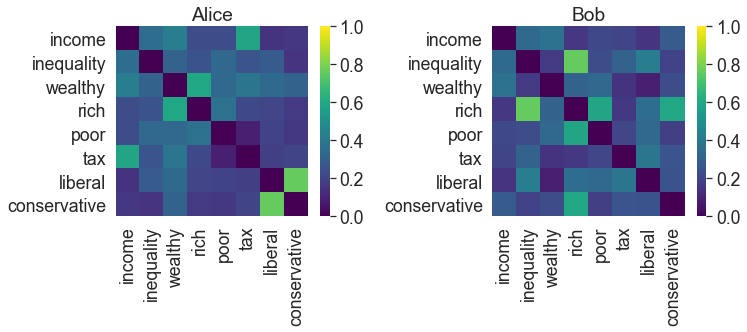

In [9]:
plot_pair_heatmap(alice, bob)

In [10]:
def sg_to_nx(sem_graph):
    edge_bunch = []
    coords = list(itertools.combinations_with_replacement(list(range(sem_graph.adj.shape[0])), 2))
    for cx, cy in coords:
        if sem_graph.adj[cx, cy] > 0:
            edge_bunch.append((
                sem_graph.labels[cx], 
                sem_graph.labels[cy], 
                sem_graph.adj[cx, cy]
            ))
    ng = nx.DiGraph()
    ng.add_nodes_from(sem_graph.labels)
    ng.add_weighted_edges_from(edge_bunch)
    return ng


def nx_draw(ng, highlight=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    weights = [8 * ng[u][v]['weight'] for u, v in ng.edges]
    colors = [(.8, .8, 1.)] * len(ng.nodes)
    if highlight is not None:
        for label in highlight:
            colors[list(ng.nodes).index(label)] = (1., .6, .6)
    nx.draw(
        ng, 
        pos=nx.circular_layout(ng), 
        width=weights,
        with_labels=True,
        arrows=False,
        node_size=3000,
        node_color=colors,
        ax=ax
    )

    
def plot_pair_nx(agent_a, agent_b, highlight_a=None, highlight_b=None, episode_graph=True):
    if episode_graph:
        ng_a = sg_to_nx(agent_a.episode_op.graph)
        ng_b = sg_to_nx(agent_b.episode_op.graph)
    else:
        ng_a = sg_to_nx(agent_a.op.graph)
        ng_b = sg_to_nx(agent_b.op.graph)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11.25, 5.5))
    nx_draw(ng_a, highlight=highlight_a, ax=ax1)
    nx_draw(ng_b, highlight=highlight_b, ax=ax2)
    ax1.set_title(agent_a.id_string)
    ax2.set_title(agent_b.id_string)
    plt.tight_layout()

/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


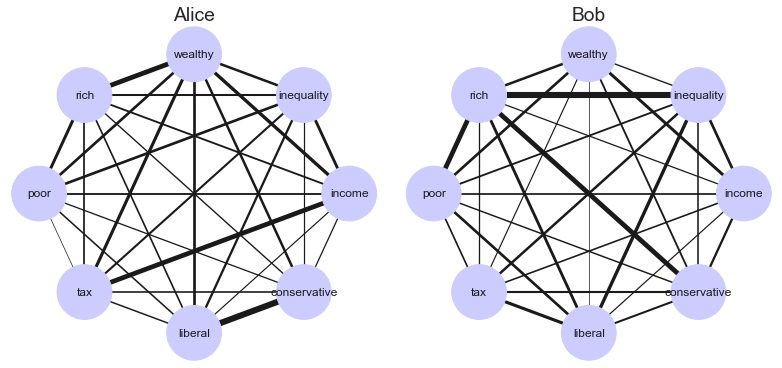

In [11]:
plot_pair_nx(alice, bob)

## Procedure

Two agents, A and B, were assigned the same vocabulary, with edge weights pulled from a word2vec model trained on Google News. For one agent, agent B, the edge weights were shuffled, ensuring that both agents had different but comparable semantic networks. Agents conversed for 50 exchanges. The correlation distance between the adjacency matrices of the memory networks for the two agents was saved after every exchange. This process was repeated 50 times, and the average distance-over-time trajectory was calculated.

In [12]:
def simulate(
    alice,
    bob,
    n_simulations=1,
    n_exchanges=50,
    method='spontaneous', # spontaneous, mean, or uniform
    plot_first_simulation=False
):
    sim_distances = []
    alices_ini = []
    bobs_ini = []
    alices_fin = []
    bobs_fin = []

    for s in range(n_simulations):
        print_log = False
        if s == 0 and plot_first_simulation:
            print_log = True

        alice = agent.Agent('Alice', op=copy.deepcopy(op_a), learning_rate=.5, print_log=print_log)

        dsm_a_shuffled = copy.deepcopy(dsm_a)
        np.random.shuffle(dsm_a_shuffled)
        graph_b = sem.SemanticGraph(dsm=dsm_a_shuffled, labels=words_a)
        op_b = gsn.GraphOperator(
            graph=graph_b, 
            operate_fx=gsn.operate_recur, 
            update_fx=my_update,
            discount=discount
        )
        bob = agent.Agent('Bob', op=op_b, learning_rate=.5, print_log=print_log)
        
        alices_ini.append(copy.deepcopy(alice))
        bobs_ini.append(copy.deepcopy(bob))

        alice.start_episode()
        bob.start_episode()

        distance = []

        if s == 0 and plot_first_simulation:
            frame = 0

            plot_pair_heatmap(alice, bob)
            plt.savefig("gif_temp/chatbots_heatmap_step_{0:02d}".format(frame))
            plt.close()

            plot_pair_nx(alice, bob)
            plt.savefig("gif_temp/chatbots_graph_step_{0:02d}".format(frame))
            plt.close()

            frame += 1

        for t in range(n_exchanges):
            r = dist.correlation(dist.squareform(alice.episode_op.graph.adj), dist.squareform(bob.episode_op.graph.adj))
            distance.append(r)
            print(f"   - distance(alice, bob): {r}")

            if method == 'spontaneous':
                pair_alice = alice.spontaneous_word_pair()
                pair_bob = bob.spontaneous_word_pair()
            elif method == 'mean':
                pair_alice = alice.mean_in_degree_word_pair()
                pair_bob = bob.mean_in_degree_word_pair()
            elif method == 'uniform':
                pair_alice = alice.uniform_word_pair()
                pair_bob = bob.uniform_word_pair()

            if s == 0 and plot_first_simulation:
                plot_pair_heatmap(alice, bob, highlight_a=pair_bob, highlight_b=pair_alice)
                plt.savefig("gif_temp/chatbots_heatmap_step_{0:02d}".format(frame))
                plt.close()

                plot_pair_nx(alice, bob, highlight_a=pair_bob, highlight_b=pair_alice)
                plt.savefig("gif_temp/chatbots_graph_step_{0:02d}".format(frame))
                plt.close()

                frame += 1

            alice.send(receivers=[bob], words=pair_alice)
            bob.send(receivers=[alice], words=pair_bob)

            if s == 0 and plot_first_simulation:
                plot_pair_heatmap(alice, bob, highlight_a=pair_bob, highlight_b=pair_alice)
                plt.savefig("gif_temp/chatbots_heatmap_step_{0:02d}".format(frame))
                plt.close()

                plot_pair_nx(alice, bob, highlight_a=pair_bob, highlight_b=pair_alice)
                plt.savefig("gif_temp/chatbots_graph_step_{0:02d}".format(frame))
                plt.close()

                frame += 1

            if s == 0 and t == (n_exchanges - 1) and plot_first_simulation:
                plot_pair_heatmap(alice, bob)
                plt.savefig("gif_temp/chatbots_heatmap_step_{0:02d}".format(frame))
                plt.close()

                plot_pair_nx(alice, bob)
                plt.savefig("gif_temp/chatbots_graph_step_{0:02d}".format(frame))
                plt.close()

        sim_distances.append(distance)
        alice.end_episode()
        bob.end_episode()
        
        alices_fin.append(copy.deepcopy(alice))
        bobs_fin.append(copy.deepcopy(bob))

    return alice, bob, sim_distances, alices_ini, bobs_ini, alices_fin, bobs_fin

### Spontaneous word pairs

In [13]:
alice_spont, bob_spont, sim_distances_spont, alices_ini, bobs_ini, alices_fin, bobs_fin = simulate(
    copy.deepcopy(alice),
    copy.deepcopy(bob),
    n_simulations=100,
    n_exchanges=50,
    method='spontaneous',
    plot_first_simulation=False
)

data_dict_spont = {
    'sim_i': [],
    'time': [],
    'distance': []
}

for sim_i, sim_distance in enumerate(sim_distances_spont):
    for time, distance in enumerate(sim_distance):
        data_dict_spont['sim_i'].append(sim_i)
        data_dict_spont['time'].append(time)
        data_dict_spont['distance'].append(distance)
sim_distance_data_spont = pd.DataFrame(data_dict_spont)

   - distance(alice, bob): 0.8736549374937739
   - distance(alice, bob): 0.9237526582084472
   - distance(alice, bob): 0.8978574297576778
   - distance(alice, bob): 0.8348379537727301
   - distance(alice, bob): 0.7962631334092295
   - distance(alice, bob): 0.7607937435137733
   - distance(alice, bob): 0.7914677655326829
   - distance(alice, bob): 0.771102373948882
   - distance(alice, bob): 0.8168100996667221
   - distance(alice, bob): 0.8263921016634855
   - distance(alice, bob): 0.733175548316914
   - distance(alice, bob): 0.7381723264919522
   - distance(alice, bob): 0.6151910025411453
   - distance(alice, bob): 0.616021631847554
   - distance(alice, bob): 0.6762486649378482
   - distance(alice, bob): 0.5532227079264753
   - distance(alice, bob): 0.5593114842783913
   - distance(alice, bob): 0.5243549611738465
   - distance(alice, bob): 0.5033928277409929
   - distance(alice, bob): 0.4758475790821558
   - distance(alice, bob): 0.3860478542366488
   - distance(alice, bob): 0.35780801

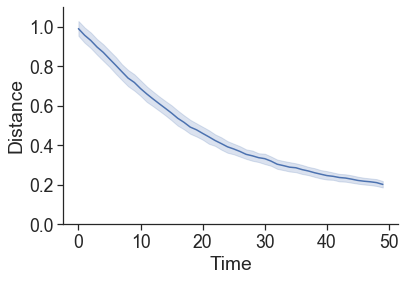

In [14]:
sns.set_style('ticks')
ax = sns.lineplot(x='time', y='distance', data=sim_distance_data_spont)
ax.set_ylabel('Distance')
ax.set_xlabel('Time')
ax.set_ylim([0, 1.1])
sns.despine()

In [16]:
adj_ini = []
adj_fin = []

for a, b in zip(alices_ini, bobs_ini):
    adj_ini.append(dist.squareform(a.op.graph.adj))
    adj_ini.append(dist.squareform(b.op.graph.adj))
    
for a, b in zip(alices_fin, bobs_fin):
    adj_fin.append(dist.squareform(a.op.graph.adj))
    adj_fin.append(dist.squareform(b.op.graph.adj))

In [17]:
mean_ini = [np.mean(x) for x in adj_ini]
mean_fin = [np.mean(x) for x in adj_fin]

var_ini = [np.var(x) for x in adj_ini]
var_fin = [np.var(x) for x in adj_fin]

In [18]:
bayes_mvs(adj_ini)

(Mean(statistic=0.29555122535914213, minmax=(0.2922612468656707, 0.2988412038526136)),
 Variance(statistic=0.022403693955931052, minmax=(0.021707279347603862, 0.023100108564258242)),
 Std_dev(statistic=0.149678635602851, minmax=(0.14735226950015942, 0.15200500170554257)))

In [19]:
bayes_mvs(adj_fin)

(Mean(statistic=0.2902011126251926, minmax=(0.28625431519136957, 0.29414791005901564)),
 Variance(statistic=0.0322420901339782, minmax=(0.031239850832884723, 0.03324432943507167)),
 Std_dev(statistic=0.1795608257220327, minmax=(0.17677001849260676, 0.18235163295145862)))

In [20]:
ttest_ind(var_ini, var_fin)

Ttest_indResult(statistic=-22.781190856802, pvalue=3.902736794712355e-74)

### Mean in-degree word pairs

In [21]:
alice_mean, bob_mean, sim_distances_mean, _, _, _, _ = simulate(
    copy.deepcopy(alice),
    copy.deepcopy(bob),
    n_simulations=100,
    n_exchanges=50,
    method='mean',
    plot_first_simulation=False
)

data_dict_mean = {
    'sim_i': [],
    'time': [],
    'distance': []
}

for sim_i, sim_distance in enumerate(sim_distances_mean):
    for time, distance in enumerate(sim_distance):
        data_dict_mean['sim_i'].append(sim_i)
        data_dict_mean['time'].append(time)
        data_dict_mean['distance'].append(distance)
sim_distance_data_mean = pd.DataFrame(data_dict_mean)

   - distance(alice, bob): 1.2642944199143922
   - distance(alice, bob): 1.2596036933810457
   - distance(alice, bob): 1.2678978126824274
   - distance(alice, bob): 1.3286418624557674
   - distance(alice, bob): 1.1952230078787043
   - distance(alice, bob): 1.2041150716503157
   - distance(alice, bob): 1.169928727393338
   - distance(alice, bob): 1.165346516645727
   - distance(alice, bob): 1.2312126324025985
   - distance(alice, bob): 1.2987304798136396
   - distance(alice, bob): 1.2693278217898887
   - distance(alice, bob): 1.2877251465386652
   - distance(alice, bob): 1.3100143070570813
   - distance(alice, bob): 1.2550608657151974
   - distance(alice, bob): 1.23292298047923
   - distance(alice, bob): 1.2166727535679038
   - distance(alice, bob): 1.179087582326251
   - distance(alice, bob): 1.153640470765937
   - distance(alice, bob): 1.2478183133653762
   - distance(alice, bob): 1.183688565845869
   - distance(alice, bob): 1.1869488809081012
   - distance(alice, bob): 1.093102151731

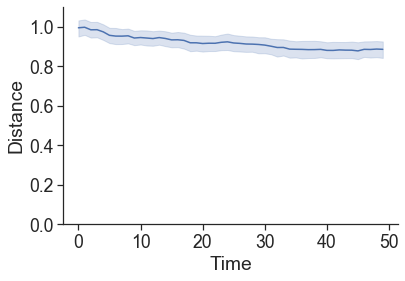

In [22]:
sns.set_style('ticks')
ax = sns.lineplot(x='time', y='distance', data=sim_distance_data_mean)
ax.set_ylabel('Distance')
ax.set_xlabel('Time')
ax.set_ylim([0, 1.1])
sns.despine()

### Uniform in-degree word pairs

In [23]:
alice_unif, bob_unif, sim_distances_unif, _, _, _, _ = simulate(
    copy.deepcopy(alice),
    copy.deepcopy(bob),
    n_simulations=100,
    n_exchanges=50,
    method='uniform',
    plot_first_simulation=False
)

data_dict_unif = {
    'sim_i': [],
    'time': [],
    'distance': []
}

for sim_i, sim_distance in enumerate(sim_distances_unif):
    for time, distance in enumerate(sim_distance):
        data_dict_unif['sim_i'].append(sim_i)
        data_dict_unif['time'].append(time)
        data_dict_unif['distance'].append(distance)
sim_distance_data_unif = pd.DataFrame(data_dict_unif)

   - distance(alice, bob): 1.1023898904881986
   - distance(alice, bob): 1.1819988576571274
   - distance(alice, bob): 1.220063059381283
   - distance(alice, bob): 1.1882108168664127
   - distance(alice, bob): 1.2372543248229422
   - distance(alice, bob): 1.2298998839716875
   - distance(alice, bob): 1.1940592133832286
   - distance(alice, bob): 1.1296961672017214
   - distance(alice, bob): 1.168999662082943
   - distance(alice, bob): 1.1463819835670304
   - distance(alice, bob): 1.1210165713809301
   - distance(alice, bob): 1.1356925538963574
   - distance(alice, bob): 1.1622128102954379
   - distance(alice, bob): 1.0906967048755827
   - distance(alice, bob): 1.1183622041955628
   - distance(alice, bob): 1.038428829326139
   - distance(alice, bob): 1.0717329343467936
   - distance(alice, bob): 1.1274283803534415
   - distance(alice, bob): 1.1368487434770391
   - distance(alice, bob): 1.1009582846209742
   - distance(alice, bob): 1.0634430046616108
   - distance(alice, bob): 1.06967056

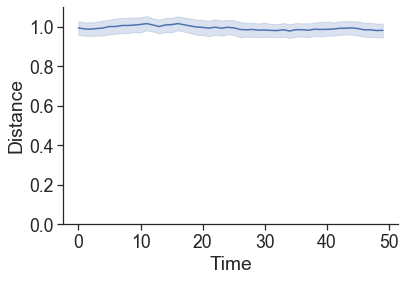

In [24]:
sns.set_style('ticks')
ax = sns.lineplot(x='time', y='distance', data=sim_distance_data_unif)
ax.set_ylabel('Distance')
ax.set_xlabel('Time')
ax.set_ylim([0, 1.1])
sns.despine()

### All word generation strategies

In [25]:
data_dict_all = {
    'method': [],
    'sim_i': [],
    'time': [],
    'distance': []
}

for sim_i, sim_distance in enumerate(sim_distances_spont):
    for time, distance in enumerate(sim_distance):
        data_dict_all['method'].append('Spontaneous')
        data_dict_all['sim_i'].append(sim_i)
        data_dict_all['time'].append(time)
        data_dict_all['distance'].append(distance)
for sim_i, sim_distance in enumerate(sim_distances_mean):
    for time, distance in enumerate(sim_distance):
        data_dict_all['method'].append('Mean in-degree')
        data_dict_all['sim_i'].append(sim_i)
        data_dict_all['time'].append(time)
        data_dict_all['distance'].append(distance)
for sim_i, sim_distance in enumerate(sim_distances_unif):
    for time, distance in enumerate(sim_distance):
        data_dict_all['method'].append('Uniform')
        data_dict_all['sim_i'].append(sim_i)
        data_dict_all['time'].append(time)
        data_dict_all['distance'].append(distance)
sim_distance_data_all = pd.DataFrame(data_dict_all)

In [26]:
sim_distance_data_all.head()

,method,sim_i,time,distance
0,Spontaneous,0,0,0.873655
1,Spontaneous,0,1,0.923753
2,Spontaneous,0,2,0.897857
3,Spontaneous,0,3,0.834838
4,Spontaneous,0,4,0.796263


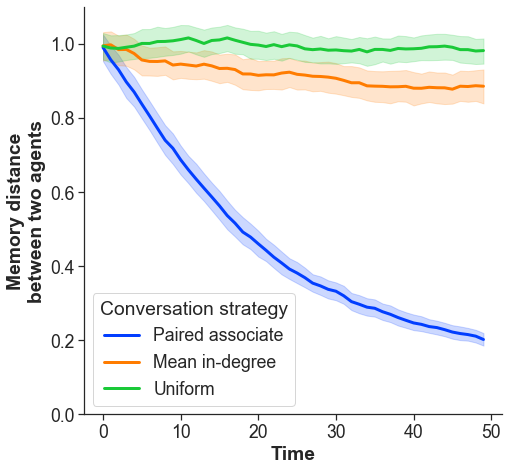

In [27]:
sns.set_style('ticks')
sns.set_palette("bright")
fig, ax = plt.subplots(figsize=(7.5,7.5))
g = sns.lineplot(x='time', y='distance', hue='method', data=sim_distance_data_all, legend=False, ax=ax, linewidth=3)
ax.set_ylabel('Memory distance\nbetween two agents', weight='bold')
ax.set_xlabel('Time', weight='bold')
plt.legend(title='Conversation strategy', loc='lower left', labels=['Paired associate', 'Mean in-degree', 'Uniform'])
ax.set_ylim([0, 1.1])
sns.despine()

### Statistics

In [28]:
df = sim_distance_data_all

In [29]:
bayes_mvs(df[(df['method'] == 'Spontaneous') & (df['time'] == 0)]['distance'])

(Mean(statistic=0.9897590004269203, minmax=(0.9582621039195232, 1.0212558969343175)),
 Variance(statistic=0.03672638345230589, minmax=(0.028910146420162756, 0.046237881917248265)),
 Std_dev(statistic=0.1911480123136052, minmax=(0.17002983979338085, 0.21502995586022022)))

In [30]:
bayes_mvs(df[(df['method'] == 'Uniform') & (df['time'] == 0)]['distance'])

(Mean(statistic=0.9935919540497413, minmax=(0.9630452379598219, 1.0241386701396606)),
 Variance(statistic=0.034543925976029254, minmax=(0.027192167156648454, 0.043490205680394106)),
 Std_dev(statistic=0.18538156805146894, minmax=(0.16490047652038017, 0.20854305474024804)))

In [31]:
bayes_mvs(df[(df['method'] == 'Mean in-degree') & (df['time'] == 0)]['distance'])

(Mean(statistic=0.9941132797012163, minmax=(0.960897337365803, 1.0273292220366297)),
 Variance(statistic=0.040844707768309854, minmax=(0.03215199459004881, 0.05142278104208622)),
 Std_dev(statistic=0.20158053835705564, minmax=(0.17930977271205498, 0.22676591684396974)))

In [32]:
bayes_mvs(df[(df['method'] == 'Spontaneous') & (df['time'] == 49)]['distance'])

(Mean(statistic=0.20181609215550517, minmax=(0.18758946150704442, 0.21604272280396591)),
 Variance(statistic=0.00749284502984464, minmax=(0.005898191614693191, 0.009433362371879412)),
 Std_dev(statistic=0.0863384165400051, minmax=(0.07679968499084609, 0.09712549805215627)))

In [33]:
bayes_mvs(df[(df['method'] == 'Uniform') & (df['time'] == 49)]['distance'])

(Mean(statistic=0.9813622667505278, minmax=(0.9522176392841895, 1.0105068942168662)),
 Variance(statistic=0.03144558324133877, minmax=(0.024753224530128404, 0.039589445735113186)),
 Std_dev(statistic=0.17687258833589295, minmax=(0.1573315751212337, 0.19897096706583395)))

In [34]:
bayes_mvs(df[(df['method'] == 'Mean in-degree') & (df['time'] == 49)]['distance'])

(Mean(statistic=0.8851763665703103, minmax=(0.8500544172898802, 0.9202983158507404)),
 Variance(statistic=0.04566672426527628, minmax=(0.035947772716386134, 0.057493616458791474)),
 Std_dev(statistic=0.21314769193075203, minmax=(0.1895989786797021, 0.23977826519263887)))

In [35]:
ttest_ind(
    df[(df['method'] == 'Spontaneous') & (df['time'] == 49)]['distance'].values, 
    df[(df['method'] == 'Uniform') & (df['time'] == 49)]['distance'].values,
    equal_var=False
)

Ttest_indResult(statistic=-39.91024245498742, pvalue=1.2650599501529453e-79)

In [36]:
ttest_ind(
    df[(df['method'] == 'Spontaneous') & (df['time'] == 49)]['distance'].values, 
    df[(df['method'] == 'Mean in-degree') & (df['time'] == 49)]['distance'].values,
    equal_var=False
)

Ttest_indResult(statistic=-29.942684334294437, pvalue=2.3657371869327582e-60)

In [37]:
ttest_ind(
    df[(df['method'] == 'Mean in-degree') & (df['time'] == 49)]['distance'].values, 
    df[(df['method'] == 'Uniform') & (df['time'] == 49)]['distance'].values,
    equal_var=False
)

Ttest_indResult(statistic=-3.499300947783369, pvalue=0.0005801158928114644)

In [38]:
dof = (
    len(df[(df['method'] == 'Mean in-degree') & (df['time'] == 49)]['distance']) + 
    len(df[(df['method'] == 'Spontaneous') & (df['time'] == 49)]['distance']) - 2
)
dof

198

### Plot end state

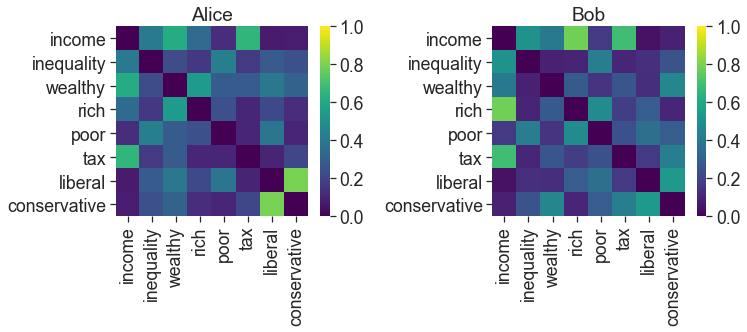

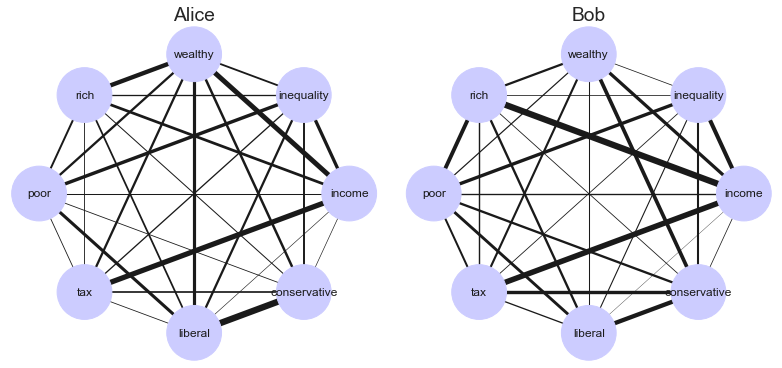

In [39]:
plot_pair_heatmap(alices_fin[0], bobs_fin[0], episode_graph=False)
plot_pair_nx(alices_fin[0], bobs_fin[0], episode_graph=False)